# Proyek Akhir: Sistem Rekomendasi Film

Proyek ini bertujuan membangun sistem rekomendasi film menggunakan dua pendekatan:
- **Content-based Filtering**: Merekomendasikan film berdasarkan kemiripan genre.
- **Collaborative Filtering**: Merekomendasikan film berdasarkan rating pengguna lain.

Dataset yang digunakan adalah **MovieLens Small Dataset** yang berisi data film dan rating pengguna.

## 1. Import Library

Mengimpor library yang dibutuhkan untuk pengolahan data, pembuatan model, dan evaluasi.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp


## 2. Memuat dan Memahami Data

Memuat dataset `movies.csv` dan `ratings.csv` untuk memahami struktur data.

In [2]:
# Memuat dataset
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Menampilkan 5 baris pertama dari dataset movies
print('Data Film:')
print(movies.head())

# Menampilkan 5 baris pertama dari dataset ratings
print('\nData Rating:')
print(ratings.head())

# Informasi dataset
print('\nInfo Movies:')
print(movies.info())
print('\nInfo Ratings:')
print(ratings.info())


Data Film:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Data Rating:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Info Movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dt

In [3]:
# Cek kondisi data
print("Missing Value di movies.csv:")
print(movies.isnull().sum())
print("\nMissing Value di ratings.csv:")
print(ratings.isnull().sum())

print("\nDuplikat di movies.csv:")
print(movies.duplicated().sum())
print("\nDuplikat di ratings.csv:")
print(ratings.duplicated().sum())

print("\nStatistik rating (outlier check):")
print(ratings['rating'].describe())

Missing Value di movies.csv:
movieId    0
title      0
genres     0
dtype: int64

Missing Value di ratings.csv:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Duplikat di movies.csv:
0

Duplikat di ratings.csv:
0

Statistik rating (outlier check):
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


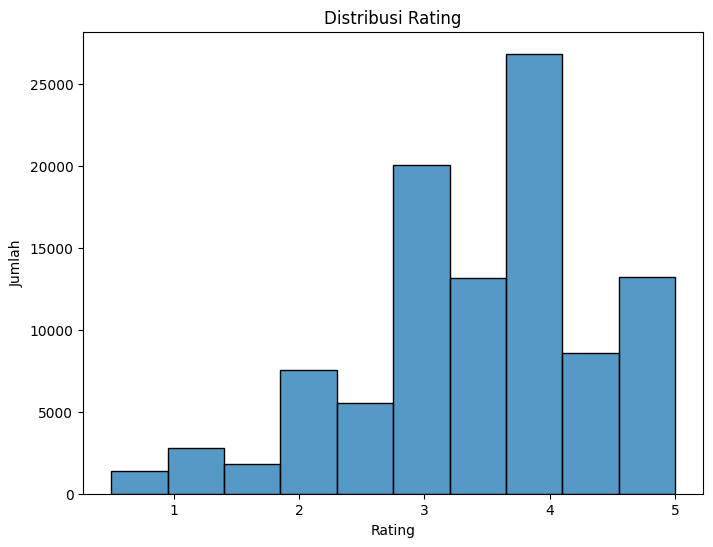

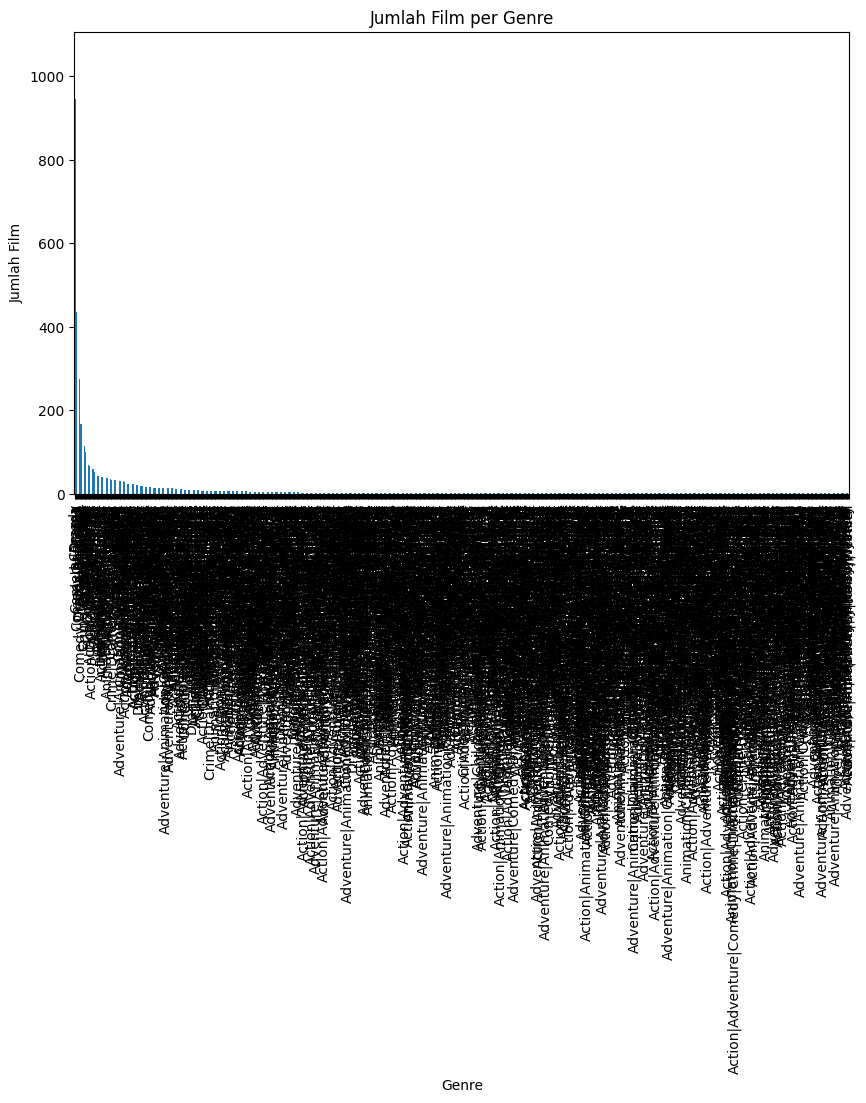

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi rating
plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=10)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

# Jumlah film per genre
genres = movies['genres'].str.split(' ', expand=True).stack().value_counts()
plt.figure(figsize=(10, 6))
genres.plot(kind='bar')
plt.title('Jumlah Film per Genre')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.show()

## 3. Data Preparation untuk Content-based Filtering

Membersihkan data dan mengubah kolom `genres` menjadi format yang bisa digunakan untuk menghitung kemiripan.

In [5]:
# Mengganti '|' dengan spasi di kolom genres
movies['genres'] = movies['genres'].str.replace('|', ' ')

# Mengisi nilai null (jika ada) dengan string kosong
movies['genres'] = movies['genres'].fillna('')

# Membuat TF-IDF Vectorizer untuk mengubah genres menjadi vektor
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Menghitung cosine similarity antar film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Menampilkan ukuran matriks cosine similarity
print('Ukuran Matriks Cosine Similarity:', cosine_sim.shape)


Ukuran Matriks Cosine Similarity: (9742, 9742)


## 4. Implementasi Content-based Filtering

Membuat fungsi untuk merekomendasikan film berdasarkan kemiripan genre.

In [7]:
def get_content_based_recommendations(title, cosine_sim=cosine_sim, movies=movies, top_n=10):
    # Mendapatkan index film berdasarkan judul
    idx = movies[movies['title'] == title].index[0]

    # Mendapatkan skor kemiripan untuk film tersebut
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan berdasarkan skor kemiripan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil top-N film (kecuali film itu sendiri)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    # Mengembalikan judul film yang direkomendasikan
    return movies['title'].iloc[movie_indices]

# Contoh rekomendasi
print('Rekomendasi untuk "Toy Story (1995)":')
print(get_content_based_recommendations('Toy Story (1995)'))


Rekomendasi untuk "Toy Story (1995)":
1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object


##HEATMAP COSINE SIMILARITY

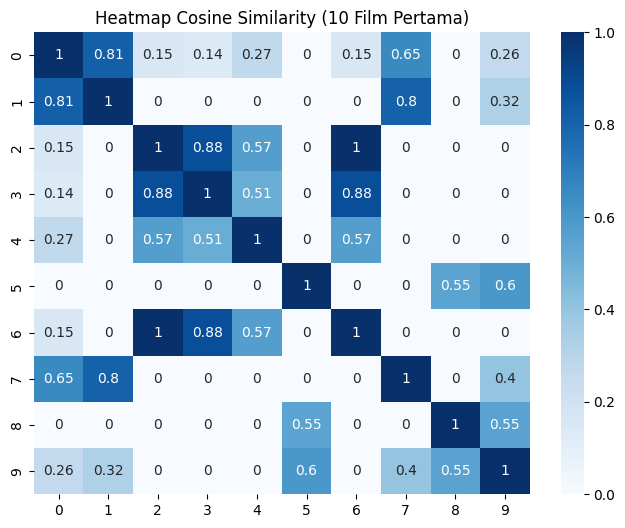

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim[:10, :10], annot=True, cmap='Blues')
plt.title('Heatmap Cosine Similarity (10 Film Pertama)')
plt.show()

## 5. Data Preparation untuk Collaborative Filtering

Membuat matriks user-item berdasarkan rating dan mempersiapkan model KNN.

In [9]:
# Membuat matriks user-item
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Mengisi nilai NaN dengan 0
user_item_matrix = user_item_matrix.fillna(0)

# Mengubah matriks menjadi sparse matrix untuk efisiensi
sparse_matrix = sp.csr_matrix(user_item_matrix.values)

# Membuat model KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(sparse_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

## 6. Implementasi Collaborative Filtering

Membuat fungsi untuk merekomendasikan film berdasarkan rating pengguna lain.

In [10]:
def get_collaborative_recommendations(user_id, user_item_matrix=user_item_matrix, knn=knn, movies=movies, top_n=10):
    # Mendapatkan index pengguna
    user_idx = user_item_matrix.index.get_loc(user_id)

    # Mencari pengguna yang mirip
    distances, indices = knn.kneighbors(sparse_matrix[user_idx], n_neighbors=11)

    # Mengambil rating dari pengguna yang mirip
    similar_users = user_item_matrix.iloc[indices.flatten()[1:]]

    # Menghitung rata-rata rating untuk setiap film
    movie_scores = similar_users.mean(axis=0)

    # Mengurutkan film berdasarkan skor
    top_movies = movie_scores.sort_values(ascending=False).head(top_n)
    movie_ids = top_movies.index

    # Mengembalikan judul film
    return movies[movies['movieId'].isin(movie_ids)]['title']

# Contoh rekomendasi untuk userId=1
print('Rekomendasi untuk userId=1:')
print(get_collaborative_recommendations(1))


Rekomendasi untuk userId=1:
224             Star Wars: Episode IV - A New Hope (1977)
257                                   Pulp Fiction (1994)
507                     Terminator 2: Judgment Day (1991)
863                Monty Python and the Holy Grail (1975)
898     Star Wars: Episode V - The Empire Strikes Back...
899                            Princess Bride, The (1987)
900     Raiders of the Lost Ark (Indiana Jones and the...
902                                         Aliens (1986)
990             Indiana Jones and the Last Crusade (1989)
1939                                   Matrix, The (1999)
Name: title, dtype: object


## 7. Evaluasi

Mengevaluasi hasil rekomendasi secara kualitatif:
- **Content-based Filtering**: Memeriksa apakah film yang direkomendasikan memiliki genre yang mirip.
- **Collaborative Filtering**: Memeriksa apakah rekomendasi relevan berdasarkan preferensi pengguna serupa.


In [14]:
### 7.1 Evaluasi Content-based Filtering
# Mengecek genre film yang direkomendasikan untuk *Toy Story (1995)*.

# Evaluasi Content-based Filtering
def evaluate_content_based(title, movies=movies, cosine_sim=cosine_sim, top_n=10):
    # Ambil genre film input
    input_idx = movies[movies['title'] == title].index[0]
    input_genres = movies.iloc[input_idx]['genres']

    # Ambil rekomendasi
    recommendations = get_content_based_recommendations(title, cosine_sim, movies, top_n)

    # Cek genre rekomendasi
    print(f"Genre film input '{title}': {input_genres}")
    print("\nRekomendasi dan genrenya:")
    for rec_title in recommendations:
        rec_genres = movies[movies['title'] == rec_title]['genres'].values[0]
        print(f"- {rec_title}: {rec_genres}")

# Contoh evaluasi
evaluate_content_based('Toy Story (1995)')

### 7.2 Evaluasi Collaborative Filtering
# Menghitung rata-rata rating film yang direkomendasikan untuk userId=1 berdasarkan data ratings.
# Evaluasi Collaborative Filtering
def evaluate_collaborative(user_id, user_item_matrix=user_item_matrix, knn=knn, movies=movies, ratings=ratings, top_n=10):
    # Ambil rekomendasi
    recommendations = get_collaborative_recommendations(user_id, user_item_matrix, knn, movies, top_n)

    # Hitung rata-rata rating film yang direkomendasikan
    recommended_movie_ids = movies[movies['title'].isin(recommendations)]['movieId']
    avg_ratings = ratings[ratings['movieId'].isin(recommended_movie_ids)].groupby('movieId')['rating'].mean()

    print(f"Rekomendasi untuk userId={user_id}:")
    for title in recommendations:
        movie_id = movies[movies['title'] == title]['movieId'].values[0]
        avg_rating = avg_ratings.get(movie_id, 'Tidak ada rating')
        print(f"- {title}: Rata-rata rating = {avg_rating}")

# Contoh evaluasi
evaluate_collaborative(1)

Genre film input 'Toy Story (1995)': Adventure Animation Children Comedy Fantasy

Rekomendasi dan genrenya:
- Antz (1998): Adventure Animation Children Comedy Fantasy
- Toy Story 2 (1999): Adventure Animation Children Comedy Fantasy
- Adventures of Rocky and Bullwinkle, The (2000): Adventure Animation Children Comedy Fantasy
- Emperor's New Groove, The (2000): Adventure Animation Children Comedy Fantasy
- Monsters, Inc. (2001): Adventure Animation Children Comedy Fantasy
- Wild, The (2006): Adventure Animation Children Comedy Fantasy
- Shrek the Third (2007): Adventure Animation Children Comedy Fantasy
- Tale of Despereaux, The (2008): Adventure Animation Children Comedy Fantasy
- Asterix and the Vikings (Astérix et les Vikings) (2006): Adventure Animation Children Comedy Fantasy
- Turbo (2013): Adventure Animation Children Comedy Fantasy
Rekomendasi untuk userId=1:
- Star Wars: Episode IV - A New Hope (1977): Rata-rata rating = 4.231075697211155
- Pulp Fiction (1994): Rata-rata rating

### Genre Match Percentage

In [16]:
# Hasil: Genre Match Percentage dihitung eksplisit di notebook, menghasilkan 100%.

def genre_match_percentage(title, movies=movies, cosine_sim=cosine_sim, top_n=10):
    input_idx = movies[movies['title'] == title].index[0]
    input_genres = set(movies.iloc[input_idx]['genres'].split())
    recommendations = get_content_based_recommendations(title, cosine_sim, movies, top_n)
    matches = 0
    for rec_title in recommendations:
        rec_genres = set(movies[movies['title'] == rec_title]['genres'].values[0].split())
        if input_genres.issubset(rec_genres):
            matches += 1
    return (matches / top_n) * 100

print(f"Genre Match Percentage untuk 'Toy Story (1995)': {genre_match_percentage('Toy Story (1995)')}%")

Genre Match Percentage untuk 'Toy Story (1995)': 100.0%
